# Importing Data

## Importing Twitter Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


training with test data

In [ ]:
import pandas as pd

test_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Test data/LabelledCaptions.csv'
test_df = pd.read_csv(test_path)

# Select and rename the specified columns
test_df = test_df[['Caption', 'Sentiment class']].rename(columns={'Caption': 'processed_tweets', 'Sentiment class': 'labels'})
test_df

,processed_tweets,labels
0,all the neutrals,1
1,2023 South Africa Player Awards!,1
2,Bucket list summer hike in Mt. Rainier Nationa...,1
3,Learning to danse under the rain,1
4,study<<<take pics because the weather is nice,1
...,...,...
235,"Anxiety , it's not easy",-1
236,I hate when people ignore the actual words tha...,-1
237,It's Been Awhile And I Still Miss You.,-1
238,𝘼𝙡𝙡 𝙩𝙝𝙚𝙨𝙚 𝙮𝙚𝙖𝙧𝙨 𝙡𝙖𝙩𝙚𝙧 𝙣𝙤𝙩𝙝𝙞𝙣𝙜 𝙘𝙝𝙖𝙣𝙜𝙚𝙙 𝙚𝙫𝙚𝙣 𝙩𝙝𝙤...,-1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df and test_df are already defined
df_processed = df[['category', 'processed_tweets']]
df_processed = df_processed.rename(columns={'category': 'labels'})

# Limit to the first 50000 entries
df_processed = df_processed.iloc[:50000]
df_processed = df_processed.reset_index(drop=True)

# Separate df_processed by class
df_negative = df_processed[df_processed['labels'] == -1.0]
df_neutral = df_processed[df_processed['labels'] == 0.0]
df_positive = df_processed[df_processed['labels'] == 1.0]

# Find the number of samples in the minority class
min_samples = min(len(df_negative), len(df_neutral), len(df_positive))
print("min_samples ", min_samples)

# Resample other classes to match the minority class size
df_negative_balanced = df_negative.sample(n=min_samples, random_state=42)
df_neutral_balanced = df_neutral.sample(n=min_samples, random_state=42)
df_positive_balanced = df_positive.sample(n=min_samples, random_state=42)

# Concatenate the balanced datasets
df_balanced = pd.concat([df_negative_balanced, df_neutral_balanced, df_positive_balanced])

# Shuffle the balanced dataset
df_processed = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Adjust labels from -1, 0, 1 to 0, 1, 2 for compatibility
df_processed['labels'] = df_processed['labels'].map({-1: 0, 0: 1, 1: 2})

# Split the balanced df_processed into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.2, random_state=42)

# Convert to lists for compatibility with further processing
X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()

# Prepare the test_df
# Ensure test_df is loaded and preprocessed similarly to df_processed before this step
test_df['labels'] = test_df['labels'].map({-1: 0, 0: 1, 1: 2})  # Adjusting test_df labels to match the training/validation scheme
X_test = test_df['processed_tweets'].tolist()
y_test = test_df['labels'].tolist()


min_samples  11043


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from collections import Counter

# Assuming preprocessing steps for df_processed are already done

# Preprocess the data: Remove NaN values and ensure tweets are strings
df_processed = df_processed.dropna(subset=['processed_tweets'])  # Drop rows where 'processed_tweets' is NaN
df_processed['processed_tweets'] = df_processed['processed_tweets'].astype(str)  # Ensure all tweets are strings


# Tokenization and vocabulary creation (based on df_processed)
all_tokens = [token for tweet in df_processed['processed_tweets'] for token in tweet.split()]
token_freqs = Counter(all_tokens)
vocab = {token: idx+2 for idx, (token, _) in enumerate(token_freqs.items())}  # Start idx+2 to leave space for <PAD> and <UNK>
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token, for words not in the vocabulary

class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, vocab):
        self.tweets = [str(tweet) for tweet in tweets]  # Convert to string to ensure compatibility
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        numericalized_tweet = [self.vocab.get(token, self.vocab['<UNK>']) for token in self.tweets[idx].split()]
        return torch.tensor(numericalized_tweet, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate_fn(batch):
    batch_tweets, batch_labels = zip(*batch)
    max_len = max(len(tweet) for tweet in batch_tweets)
    padded_tweets = [torch.cat((tweet, torch.full((max_len - len(tweet),), vocab['<PAD>'], dtype=torch.long))) for tweet in batch_tweets]
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    return torch.stack(padded_tweets), batch_labels

# Create datasets for training, validation, and testing
train_dataset = TwitterDataset(X_train, y_train, vocab)
val_dataset = TwitterDataset(X_val, y_val, vocab)
test_dataset = TwitterDataset(X_test, y_test, vocab)  # Assuming X_test and y_test are prepared from test_df

# Create DataLoader instances for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)


<ipython-input-6-5ba3b079f89a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['processed_tweets'] = df_processed['processed_tweets'].astype(str)  # Ensure all tweets are strings


continuing as normal

In [ ]:
! ls 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'

'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'


In [ ]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)

In [ ]:
import pandas as pd
#made for the addition of new data IMAGE TEXT DATA
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df_one = pd.read_csv(file_path)

df_one_processed = df_one[['category', 'processed_tweets']]
df_one_processed = df_one_processed.rename(columns={'category': 'labels'})

# Limit to the first 60000 entries
df_one_processed = df_one_processed.iloc[:60000]
df_processed = df_one_processed.reset_index(drop=True)
df_processed

,labels,processed_tweets
0,-1.0,"when modi promise "" minimum government maximum..."
1,0.0,talk all the nonsense and continue all the dra...
2,1.0,what do just say vote for modi welcome bjp tel...
3,1.0,ask his supporter prefix chowkidar their name ...
4,1.0,answer who among these the most powerful world...
...,...,...
59995,0.0,ji actually through against election commissio...
59996,-1.0,modi ji foreign policy ensure national security
59997,0.0,modi favorable among muslim you guy
59998,0.0,orop give the exserviceman mother who family p...


In [ ]:
path = '/content/drive/My Drive/APS360 Group/Data preprocessing/ImagesZeina/image_descriptions.csv'
df_two = pd.read_csv(path)
df_two = df_two[['sentiment','caption']]
df_two_processed = df_two.rename(columns={'sentiment': 'labels', 'caption': 'text'})
df_two_processed

,labels,text
0,-1,dill pickle flavored sunflower seeds Because t...
1,-1,Raquels disgusting food From the school cafete...
2,-1,This is the pathetic excuse for sushi they ha...
3,-1,Disgusting food httpwwwflickrcomphotosbenn
4,-1,New Pepsi Max Cino Supposedly coffeeflavoured ...
...,...,...
15476,1,Fantastic paint job at Kings X camden buildi...
15477,1,Starmans jacket A fantastic paint jobYay This ...
15478,1,NHRA Winston world finals These were taken wi...
15479,1,The Golden Lion Back in August The Golden Lion...


In [ ]:
#TRYIUNG AGAIN !!!!!!!!!!
import pandas as pd

# Load and preprocess the first dataframe
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df_one = pd.read_csv(file_path)
df_one_processed = df_one[['category', 'processed_tweets']]
df_one_processed = df_one_processed.rename(columns={'category': 'labels'})

# Limit to the first 50000 entries
df_one_processed = df_one_processed.iloc[:50000]

# Load and preprocess the second dataframe
path = '/content/drive/My Drive/APS360 Group/Data preprocessing/ImagesZeina/image_descriptions.csv'
df_two = pd.read_csv(path)
df_two_processed = df_two[['sentiment', 'caption']]
df_two_processed = df_two_processed.rename(columns={'sentiment': 'labels', 'caption': 'processed_tweets'})

# Concatenate the dataframes
df_processed = pd.concat([df_one_processed, df_two_processed], ignore_index=True)

# Display the resulting dataframe
df_processed


,labels,processed_tweets
0,-1.0,"when modi promise "" minimum government maximum..."
1,0.0,talk all the nonsense and continue all the dra...
2,1.0,what do just say vote for modi welcome bjp tel...
3,1.0,ask his supporter prefix chowkidar their name ...
4,1.0,answer who among these the most powerful world...
...,...,...
65476,1.0,Fantastic paint job at Kings X camden buildi...
65477,1.0,Starmans jacket A fantastic paint jobYay This ...
65478,1.0,NHRA Winston world finals These were taken wi...
65479,1.0,The Golden Lion Back in August The Golden Lion...


In [ ]:
#extension of above

from sklearn.model_selection import train_test_split

# Separate df_processed by class
df_negative = df_processed[df_processed['labels'] == -1.0]
df_neutral = df_processed[df_processed['labels'] == 0.0]
df_positive = df_processed[df_processed['labels'] == 1.0]

# Find the number of samples in the minority class
min_samples = min(len(df_negative), len(df_neutral), len(df_positive))
print("min_samples ", min_samples)

# Resample other classes to match the minority class size
df_negative_balanced = df_negative.sample(n=min_samples, random_state=42)
df_neutral_balanced = df_neutral.sample(n=min_samples, random_state=42)
df_positive_balanced = df_positive.sample(n=min_samples, random_state=42)

# Concatenate the balanced datasets
df_balanced = pd.concat([df_negative_balanced, df_neutral_balanced, df_positive_balanced])

# Shuffle the balanced dataset
df_processed = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#ADDEDDDDDDDDDD
# After df_processed is balanced and before the split
df_processed['labels'] = df_processed['labels'].map({-1: 0, 0: 1, 1: 2})


# Now, proceed with splitting the balanced df_processed into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

test_val_proportion = 0.15 / 0.25
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_val_proportion, random_state=42)

# Convert to lists for compatibility with further processing
X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

min_samples  13131


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_processed = df[['category', 'processed_tweets']]
df_processed = df_processed.rename(columns={'category': 'labels'})

# Limit to the first 50000 entries
df_processed = df_processed.iloc[:50000]
df_processed = df_processed.reset_index(drop=True)

# Separate df_processed by class
df_negative = df_processed[df_processed['labels'] == -1.0]
df_neutral = df_processed[df_processed['labels'] == 0.0]
df_positive = df_processed[df_processed['labels'] == 1.0]

# Find the number of samples in the minority class
min_samples = min(len(df_negative), len(df_neutral), len(df_positive))
print("min_samples ", min_samples)

# Resample other classes to match the minority class size
df_negative_balanced = df_negative.sample(n=min_samples, random_state=42)
df_neutral_balanced = df_neutral.sample(n=min_samples, random_state=42)
df_positive_balanced = df_positive.sample(n=min_samples, random_state=42)

# Concatenate the balanced datasets
df_balanced = pd.concat([df_negative_balanced, df_neutral_balanced, df_positive_balanced])

# Shuffle the balanced dataset
df_processed = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#ADDEDDDDDDDDDD
# After df_processed is balanced and before the split
df_processed['labels'] = df_processed['labels'].map({-1: 0, 0: 1, 1: 2})

# Now, proceed with splitting the balanced df_processed into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

test_val_proportion = 0.15 / 0.25
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_val_proportion, random_state=42)

# Convert to lists for compatibility with further processing
X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()


min_samples  11043


# Coding the model

## Defining the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return F.log_softmax(output, dim=1)  # Ensure log_softmax is applied correctly


## Preprocessing

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from collections import Counter

# Preprocess the data: Remove NaN values and ensure tweets are strings
df_processed = df_processed.dropna(subset=['processed_tweets'])  # Drop rows where 'processed_tweets' is NaN
df_processed['processed_tweets'] = df_processed['processed_tweets'].astype(str)  # Ensure all tweets are strings

# Adjust labels from -1, 0, 1 to 0, 1, 2 for compatibility with nn.CrossEntropyLoss
#df_processed['labels'] = df_processed['labels'] + 1

# Tokenization and vocabulary creation
all_tokens = [token for tweet in df_processed['processed_tweets'] for token in tweet.split()]
token_freqs = Counter(all_tokens)

vocab = {token: idx+2 for idx, (token, _) in enumerate(token_freqs.items())}  # Start idx+2 to leave space for <PAD> and <UNK>

# Add <PAD> and <UNK> tokens to the vocabulary
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token, for words not in the vocabulary

class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, vocab):
        self.tweets = tweets  # Ensure this is a list
        self.labels = labels  # Ensure this is a list
        self.vocab = vocab

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = str(self.tweets[idx])  # Convert to string to ensure compatibility with .split()
        # Use vocab.get to handle unknown tokens, defaults to '<UNK>' index if token is not found
        numericalized_tweet = [self.vocab.get(token, self.vocab['<UNK>']) for token in tweet.split()]
        return torch.tensor(numericalized_tweet, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Labels and tweets extraction
labels = df_processed['labels'].tolist()
tweets = df_processed['processed_tweets'].tolist()

dataset = TwitterDataset(tweets, labels, vocab)

def pad_collate_fn(batch):
    batch_tweets, batch_labels = zip(*batch)
    max_len = max(len(tweet) for tweet in batch_tweets)

    padded_tweets = [torch.cat((tweet, torch.full((max_len - len(tweet),), vocab['<PAD>'], dtype=torch.long))) for tweet in batch_tweets]
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)

    return torch.stack(padded_tweets), batch_labels


# Define DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)


<ipython-input-12-b9e9cbc52fed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['processed_tweets'] = df_processed['processed_tweets'].astype(str)  # Ensure all tweets are strings


In [ ]:
print(len(vocab))

35080


In [ ]:
# adjusted according to dataset and experimentations
vocab_size = len(vocab)  # Example value, adjust to your dataset's vocabulary size
embedding_dim = 100
hidden_dim = 256
output_dim = 3  # Output classes: -1, 0, 1 for negative, neutral, positive sentiments
dropout = 0.6

model = SentimentLSTM(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=3, dropout=dropout)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0002) #5e-4

##############
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [ ]:
# Create datasets
train_dataset = TwitterDataset(X_train, y_train, vocab)
val_dataset = TwitterDataset(X_val, y_val, vocab)
test_dataset = TwitterDataset(X_test, y_test, vocab)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)


## Training

In [ ]:
# Section Six: Training Function
def calculate_accuracy(y_pred, y):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y).float()  # Direct comparison without label adjustment
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, loss_fn):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in iterator:
        tweets, labels = batch
        labels = labels.long()  # Ensure labels are long if they're not already, no additional +1 adjustment
        optimizer.zero_grad()
        predictions = model(tweets)
        loss = loss_fn(predictions, labels)
        acc = calculate_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss, epoch_acc = 0, 0

    with torch.no_grad():
        for batch in iterator:
            tweets, labels = batch
            labels = labels.long()  # Correctly ensure labels are integers, without +1 adjustment
            predictions = model(tweets)
            loss = loss_fn(predictions, labels)
            acc = calculate_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
# Define the number of epochs
num_epochs = 100  # Adjusted based on previous advice

# Training and evaluation loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)  # Unpack the returned tuple
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)  # Unpack the returned tuple

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


Epoch 1/10 - Training Loss: 1.0236, Training Accuracy: 0.4595, Validation Loss: 1.0056, Validation Accuracy: 0.4895
Epoch 2/10 - Training Loss: 1.0126, Training Accuracy: 0.4643, Validation Loss: 1.0049, Validation Accuracy: 0.4375
Epoch 3/10 - Training Loss: 0.9997, Training Accuracy: 0.4723, Validation Loss: 0.9687, Validation Accuracy: 0.5037
Epoch 4/10 - Training Loss: 0.9683, Training Accuracy: 0.4891, Validation Loss: 0.9862, Validation Accuracy: 0.4647
Epoch 5/10 - Training Loss: 0.9303, Training Accuracy: 0.5203, Validation Loss: 0.9418, Validation Accuracy: 0.5126
Epoch 6/10 - Training Loss: 0.8849, Training Accuracy: 0.5403, Validation Loss: 0.8711, Validation Accuracy: 0.5499
Epoch 7/10 - Training Loss: 0.8370, Training Accuracy: 0.5678, Validation Loss: 0.9111, Validation Accuracy: 0.5336
Epoch 8/10 - Training Loss: 0.8162, Training Accuracy: 0.5899, Validation Loss: 0.8343, Validation Accuracy: 0.5939
Epoch 9/10 - Training Loss: 0.7623, Training Accuracy: 0.6348, Validatio

Epoch 1/50 - Training Loss: 1.0827, Training Accuracy: 0.3850, Validation Loss: 1.0194, Validation Accuracy: 0.4827
Epoch 2/50 - Training Loss: 1.0311, Training Accuracy: 0.4587, Validation Loss: 1.0063, Validation Accuracy: 0.4882
Epoch 3/50 - Training Loss: 1.0251, Training Accuracy: 0.4577, Validation Loss: 1.0337, Validation Accuracy: 0.4559
Epoch 4/50 - Training Loss: 1.0213, Training Accuracy: 0.4638, Validation Loss: 1.0111, Validation Accuracy: 0.4429
Epoch 5/50 - Training Loss: 1.0179, Training Accuracy: 0.4583, Validation Loss: 0.9921, Validation Accuracy: 0.4901
Epoch 6/50 - Training Loss: 1.0151, Training Accuracy: 0.4650, Validation Loss: 0.9956, Validation Accuracy: 0.4975
Epoch 7/50 - Training Loss: 1.0044, Training Accuracy: 0.4757, Validation Loss: 0.9767, Validation Accuracy: 0.4798
Epoch 8/50 - Training Loss: 0.9936, Training Accuracy: 0.4733, Validation Loss: 0.9594, Validation Accuracy: 0.5016
Epoch 9/50 - Training Loss: 0.9871, Training Accuracy: 0.4806, Validatio

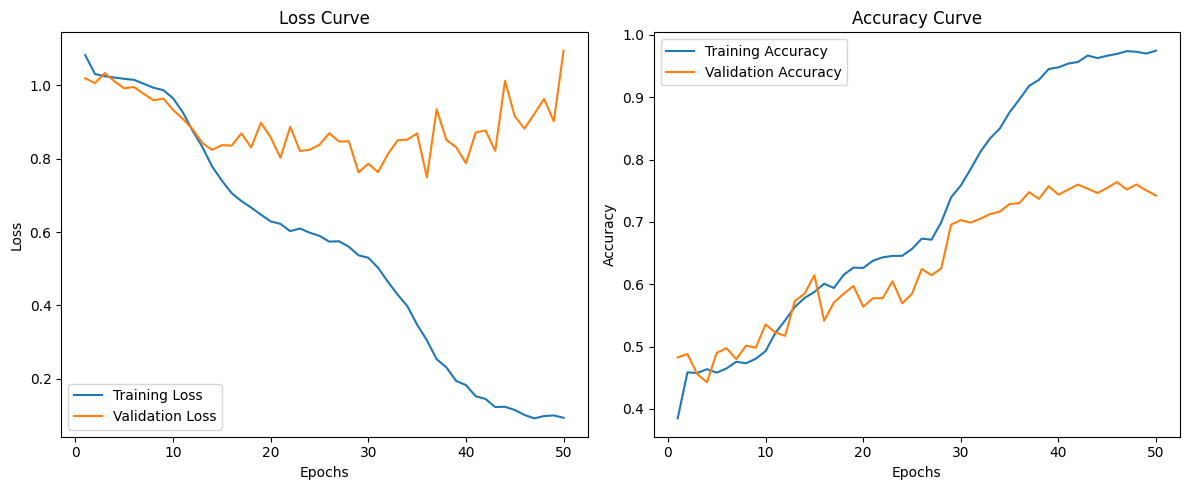

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs
num_epochs = 45  # Adjusted based on previous advice

# Initialize lists to store per-epoch metrics
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training and evaluation loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)  # Unpack the returned tuple
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)  # Unpack the returned tuple

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100 - Training Loss: 1.1013, Training Accuracy: 0.3583, Validation Loss: 1.0802, Validation Accuracy: 0.4037
Epoch 2/100 - Training Loss: 1.0504, Training Accuracy: 0.4324, Validation Loss: 1.0071, Validation Accuracy: 0.4880
Epoch 3/100 - Training Loss: 1.0270, Training Accuracy: 0.4571, Validation Loss: 1.0031, Validation Accuracy: 0.4854
Epoch 4/100 - Training Loss: 1.0185, Training Accuracy: 0.4592, Validation Loss: 1.0002, Validation Accuracy: 0.4717
Epoch 5/100 - Training Loss: 1.0129, Training Accuracy: 0.4712, Validation Loss: 1.0168, Validation Accuracy: 0.4689
Epoch 6/100 - Training Loss: 1.0098, Training Accuracy: 0.4620, Validation Loss: 0.9870, Validation Accuracy: 0.4880
Epoch 7/100 - Training Loss: 1.0006, Training Accuracy: 0.4771, Validation Loss: 0.9763, Validation Accuracy: 0.4866
Epoch 8/100 - Training Loss: 0.9969, Training Accuracy: 0.4821, Validation Loss: 0.9771, Validation Accuracy: 0.4769
Epoch 9/100 - Training Loss: 0.9983, Training Accuracy: 0.4808, 

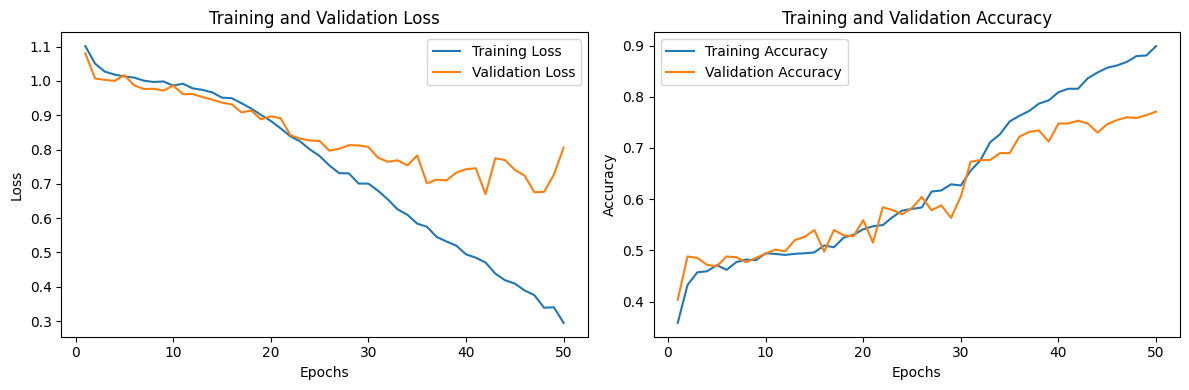

In [ ]:
# Define the number of epochs
num_epochs = 80  # Adjust based on previous advice
patience = 8  # Patience for early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
patience_counter = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training and evaluation loop with early stopping
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)

    # Update the learning rate scheduler
    #scheduler.step(val_loss)

    # Save losses and accuracies for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Plotting the training and validation losses and accuracies
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100 - Training Loss: 1.0120, Training Accuracy: 0.4619, Training F1: 0.4401, Validation Loss: 0.9752, Validation Accuracy: 0.4894, Validation F1: 0.4468
Epoch 2/100 - Training Loss: 0.9943, Training Accuracy: 0.4729, Training F1: 0.4132, Validation Loss: 0.9387, Validation Accuracy: 0.5089, Validation F1: 0.4246
Epoch 3/100 - Training Loss: 0.9336, Training Accuracy: 0.5115, Training F1: 0.5786, Validation Loss: 0.8272, Validation Accuracy: 0.5890, Validation F1: 0.5696
Epoch 4/100 - Training Loss: 0.8274, Training Accuracy: 0.6079, Training F1: 0.6945, Validation Loss: 0.7199, Validation Accuracy: 0.6927, Validation F1: 0.6825
Epoch 5/100 - Training Loss: 0.7419, Training Accuracy: 0.6823, Training F1: 0.7508, Validation Loss: 0.6288, Validation Accuracy: 0.7518, Validation F1: 0.7452
Epoch 6/100 - Training Loss: 0.6418, Training Accuracy: 0.7453, Training F1: 0.7935, Validation Loss: 0.5504, Validation Accuracy: 0.7879, Validation F1: 0.7823
Epoch 7/100 - Training Loss: 0.559

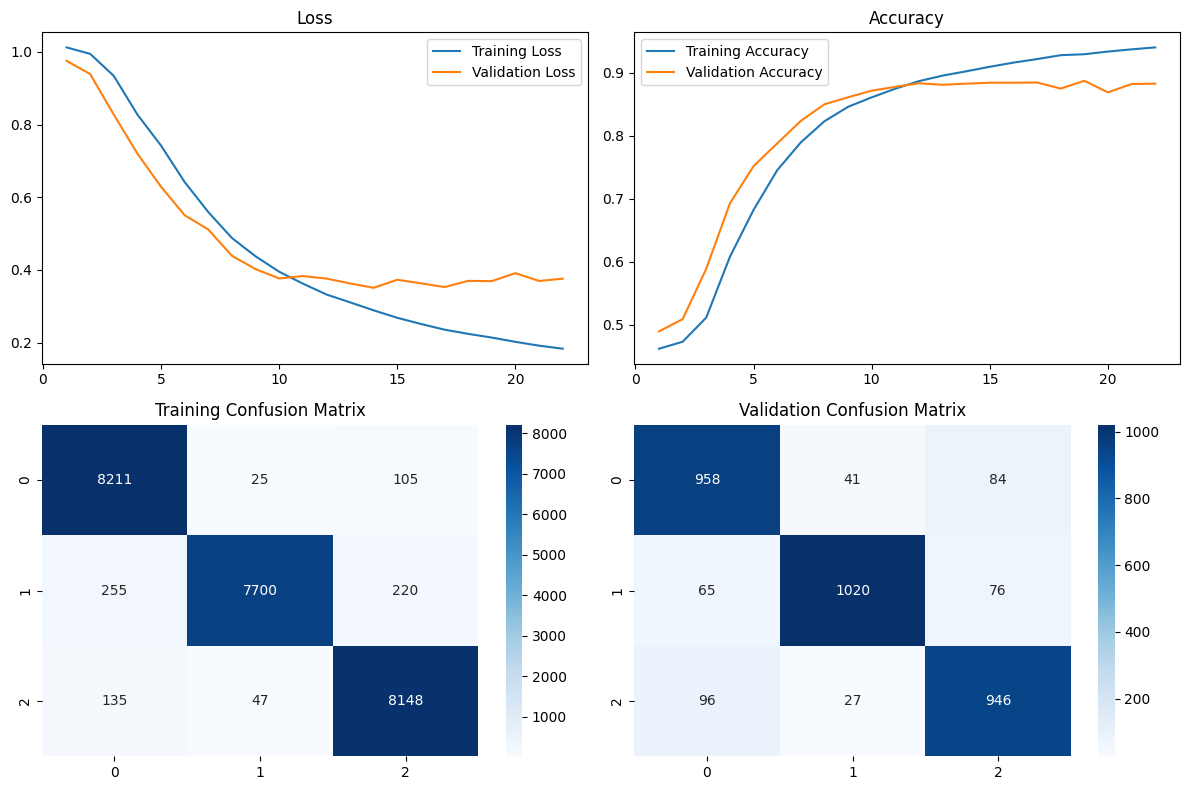

In [ ]:
# from sklearn.metrics import confusion_matrix, f1_score
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
# #########
# # Check if CUDA (GPU support) is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ###########

# # Define the number of epochs
# num_epochs = 100  # Adjust based on previous advice
# patience = 8  # Patience for early stopping

# # Initialize variables for early stopping
# best_val_loss = float('inf')
# patience_counter = 0
# # Function to calculate metrics
# def calculate_metrics(model, data_loader):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#     f1 = f1_score(all_labels, all_preds, average='weighted')
#     conf_matrix = confusion_matrix(all_labels, all_preds)
#     return f1, conf_matrix

# # Initialize metrics storage
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []
# train_f1_scores, val_f1_scores = [], []
# train_conf_matrices, val_conf_matrices = [], []

# # Training loop with metrics calculation
# for epoch in range(100):
#     train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
#     val_loss, val_acc = evaluate(model, val_loader, loss_fn)

#     train_f1, train_conf_matrix = calculate_metrics(model, train_loader)
#     val_f1, val_conf_matrix = calculate_metrics(model, val_loader)

#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)
#     train_f1_scores.append(train_f1)
#     val_f1_scores.append(val_f1)
#     train_conf_matrices.append(train_conf_matrix)
#     val_conf_matrices.append(val_conf_matrix)

#     print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}')

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1
#     if patience_counter >= patience:
#         print("Early stopping triggered.")
#         break

# # Plot loss and accuracy
# epochs_range = range(1, epoch + 2)  # Adjust range to number of epochs actually completed

# plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
# plt.plot(epochs_range, train_losses, label='Training Loss')
# plt.plot(epochs_range, val_losses, label='Validation Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
# plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
# plt.title('Accuracy')
# plt.legend()

# # Plot last epoch's confusion matrix for training and validation
# plt.subplot(2, 2, 3)
# sns.heatmap(train_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
# plt.title('Training Confusion Matrix')

# plt.subplot(2, 2, 4)
# sns.heatmap(val_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
# plt.title('Validation Confusion Matrix')

# plt.tight_layout()
# plt.show()


Epoch 1/100 - Training Loss: 1.0481, Training Accuracy: 0.4282, Training F1: 0.3738, Validation Loss: 1.0054, Validation Accuracy: 0.4764, Validation F1: 0.3908
Epoch 2/100 - Training Loss: 1.0135, Training Accuracy: 0.4651, Training F1: 0.4689, Validation Loss: 0.9829, Validation Accuracy: 0.4898, Validation F1: 0.4838
Epoch 3/100 - Training Loss: 0.9969, Training Accuracy: 0.4732, Training F1: 0.5095, Validation Loss: 0.9178, Validation Accuracy: 0.5352, Validation F1: 0.5171
Epoch 4/100 - Training Loss: 0.9175, Training Accuracy: 0.5187, Training F1: 0.5449, Validation Loss: 0.8083, Validation Accuracy: 0.5897, Validation F1: 0.5455
Epoch 5/100 - Training Loss: 0.8074, Training Accuracy: 0.6202, Training F1: 0.7125, Validation Loss: 0.6834, Validation Accuracy: 0.7174, Validation F1: 0.7102
Epoch 6/100 - Training Loss: 0.7159, Training Accuracy: 0.6983, Training F1: 0.7636, Validation Loss: 0.6142, Validation Accuracy: 0.7607, Validation F1: 0.7555
Epoch 7/100 - Training Loss: 0.636

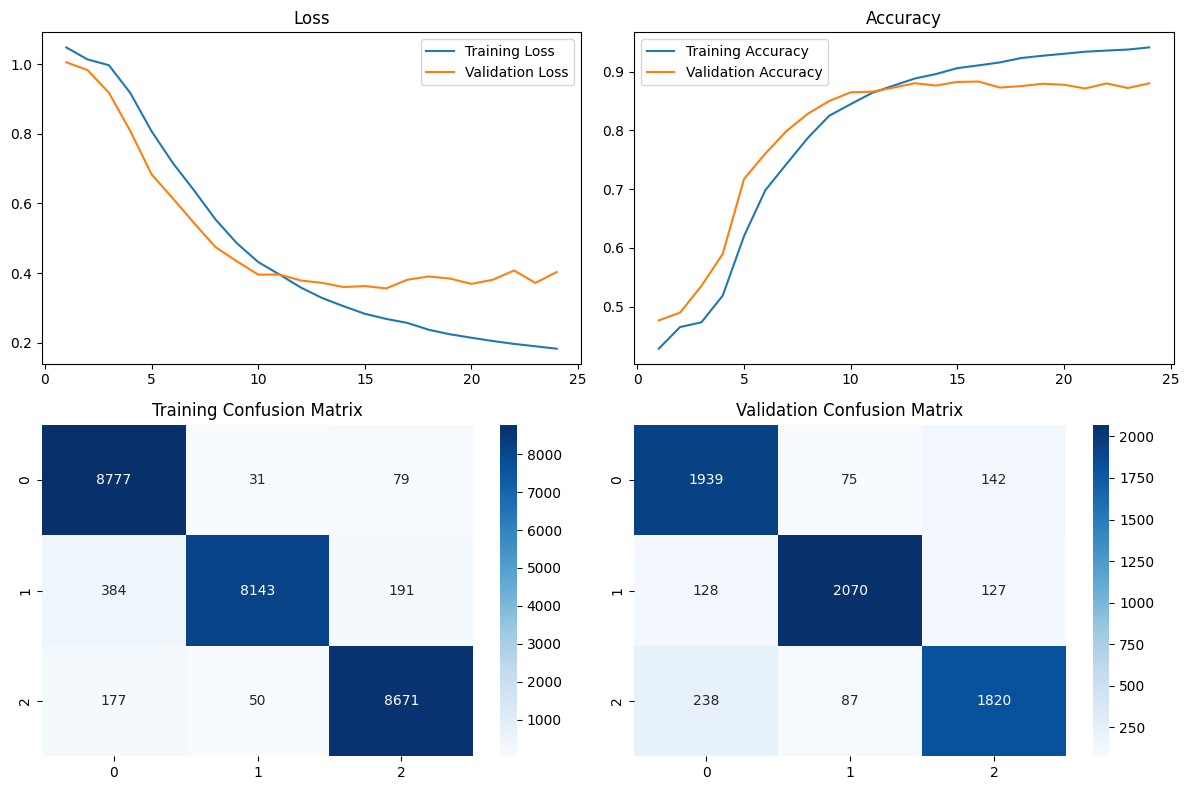

In [ ]:
#copy paste from above for test set training version and NOT saving any weights
#COPY THIS FOR THE REPORT!!!!!!!
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
#########
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
###########

# Define the number of epochs
num_epochs = 100  # Adjust based on previous advice
patience = 8  # Patience for early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
patience_counter = 0
# Function to calculate metrics
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return f1, conf_matrix

# Initialize metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_conf_matrices, val_conf_matrices = [], []

# Training loop with metrics calculation
for epoch in range(100):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)

    train_f1, train_conf_matrix = calculate_metrics(model, train_loader)
    val_f1, val_conf_matrix = calculate_metrics(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_conf_matrices.append(train_conf_matrix)
    val_conf_matrices.append(val_conf_matrix)

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Plot loss and accuracy
epochs_range = range(1, epoch + 2)  # Adjust range to number of epochs actually completed

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot last epoch's confusion matrix for training and validation
plt.subplot(2, 2, 3)
sns.heatmap(train_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(val_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')

plt.tight_layout()
plt.show()

Epoch 1/100 - Training Loss: 1.0514, Training Accuracy: 0.4219, Training F1: 0.4528, Validation Loss: 0.9931, Validation Accuracy: 0.4787, Validation F1: 0.4749
Epoch 2/100 - Training Loss: 1.0147, Training Accuracy: 0.4641, Training F1: 0.4691, Validation Loss: 0.9861, Validation Accuracy: 0.4865, Validation F1: 0.4816
Epoch 3/100 - Training Loss: 1.0017, Training Accuracy: 0.4696, Training F1: 0.4649, Validation Loss: 0.9573, Validation Accuracy: 0.5077, Validation F1: 0.4736
Epoch 4/100 - Training Loss: 0.9431, Training Accuracy: 0.5048, Training F1: 0.5529, Validation Loss: 0.8356, Validation Accuracy: 0.5759, Validation F1: 0.5477
Epoch 5/100 - Training Loss: 0.8308, Training Accuracy: 0.6025, Training F1: 0.6927, Validation Loss: 0.7223, Validation Accuracy: 0.6984, Validation F1: 0.6875
Epoch 6/100 - Training Loss: 0.7275, Training Accuracy: 0.6936, Training F1: 0.7514, Validation Loss: 0.6049, Validation Accuracy: 0.7581, Validation F1: 0.7519
Epoch 7/100 - Training Loss: 0.624

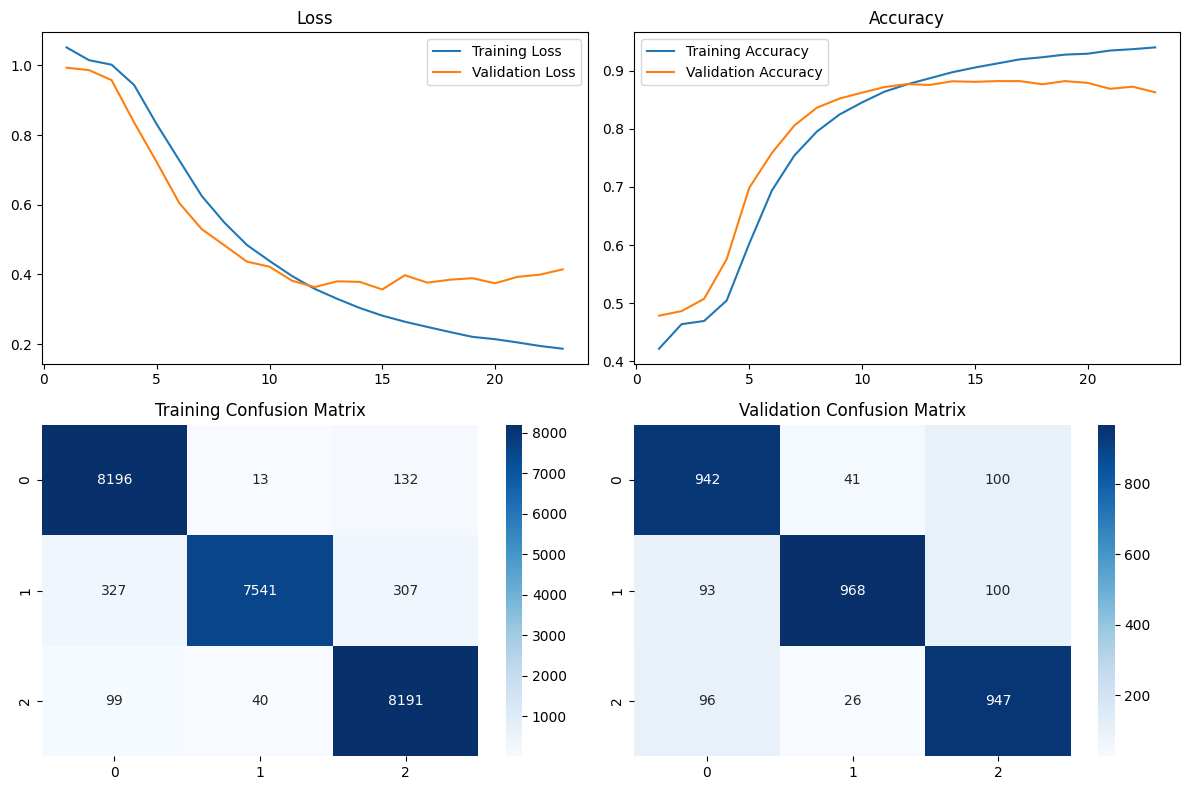

In [ ]:
'''run this one'''
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs
num_epochs = 100  # Adjust based on previous advice
patience = 8  # Patience for early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
patience_counter = 0

# Function to calculate metrics
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return f1, conf_matrix

# Initialize metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_conf_matrices, val_conf_matrices = [], []

# Training loop with metrics calculation
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)

    train_f1, train_conf_matrix = calculate_metrics(model, train_loader)
    val_f1, val_conf_matrix = calculate_metrics(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_conf_matrices.append(train_conf_matrix)
    val_conf_matrices.append(val_conf_matrix)

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'drive/MyDrive/APS360 Group/Data preprocessing/best_model_3.pth')
        torch.save({
    'state_dict': model.state_dict(),
    'drive/MyDrive/APS360 Group/Data preprocessing/vocab_size': vocab_size,
    'drive/MyDrive/APS360 Group/Data preprocessing/vocab': vocab,
    # include any other configs as needed
}, 'drive/MyDrive/APS360 Group/Data preprocessing/best_model_3.pth')

        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Plotting code remains unchanged
# Plot loss and accuracy
epochs_range = range(1, epoch + 2)  # Adjust range to number of epochs actually completed

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot last epoch's confusion matrix for training and validation
plt.subplot(2, 2, 3)
sns.heatmap(train_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(val_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(f"Inputs are on {inputs.device}, Labels are on {labels.device}")
    # Proceed with your computations here
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(f"Inputs are on {inputs.device}, Labels are on {labels.device}")
    # Proceed with your computations here


Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are on cuda:0, Labels are on cuda:0
Inputs are 

In [ ]:
#RUNNING THIS AS A COPY OF ABOVE TO NOT LOSE THE SAVED DATA ABOVE
'''run this one'''
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs
num_epochs = 100  # Adjust based on previous advice
patience = 8  # Patience for early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
patience_counter = 0

model = model.to(device)  # Make sure your model is on the correct device

def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the correct device
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Move predictions back to CPU for numpy operations
            all_labels.extend(labels.cpu().numpy())  # Labels are also moved back to CPU for numpy operations
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return f1, conf_matrix

# Initialize metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_conf_matrices, val_conf_matrices = [], []

# Training loop with metrics calculation
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)

    train_f1, train_conf_matrix = calculate_metrics(model, train_loader)
    val_f1, val_conf_matrix = calculate_metrics(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_conf_matrices.append(train_conf_matrix)
    val_conf_matrices.append(val_conf_matrix)

    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'drive/MyDrive/APS360 Group/Data preprocessing/best_model_2.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Plotting code remains unchanged
# Plot loss and accuracy
epochs_range = range(1, epoch + 2)  # Adjust range to number of epochs actually completed

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot last epoch's confusion matrix for training and validation
plt.subplot(2, 2, 3)
sns.heatmap(train_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(val_conf_matrices[-1], annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')

plt.tight_layout()
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

Test Loss: 0.7849, Test Accuracy: 0.7994, Test F1 Score: 0.7983


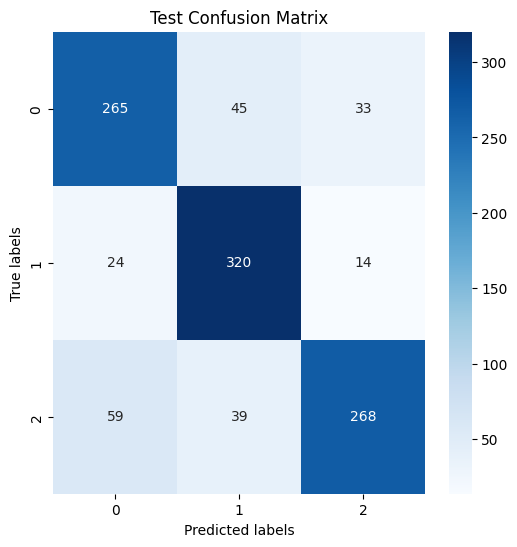

In [ ]:
#FOR NEXT PROJECT MAKE SURE TO RERUN THIS!!!!!!!!!!

from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Ensure the model, test_loader, and device are defined and available in your context

# Function to calculate metrics on the test set
def calculate_test_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss(outputs, labels)  # or your loss function if different
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, f1, conf_matrix

# Calculate test metrics
test_loss, test_accuracy, test_f1, test_conf_matrix = calculate_test_metrics(model, test_loader, device)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}')

# Plotting the confusion matrix for the test set
plt.figure(figsize=(6, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


Test Loss: 3.5465, Test Accuracy: 0.4625, Test F1 Score: 0.4398, Test Precision: 0.5244, Test Recall: 0.4625


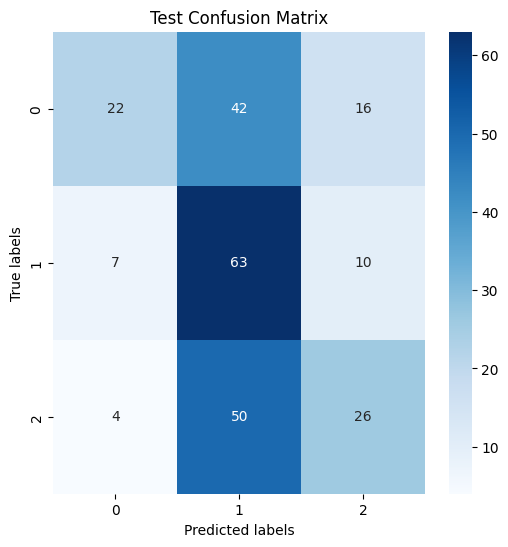

In [ ]:
#SAME THING AS ABOVE BUT WITH MORE METRICS
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

# Ensure the model, test_loader, and device are defined and available in your context

def calculate_test_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    loss_function = nn.CrossEntropyLoss()  # Instantiate your loss function here

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, f1, precision, recall, conf_matrix

# Calculate test metrics
test_loss, test_accuracy, test_f1, test_precision, test_recall, test_conf_matrix = calculate_test_metrics(model, test_loader, device)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

# Plotting the confusion matrix for the test set
plt.figure(figsize=(6, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
from collections import Counter

# Check the distribution in the training set
train_labels_count = Counter(y_train)
print("Training set label distribution:", train_labels_count)

# Check the distribution in the validation set
val_labels_count = Counter(y_val)
print("Validation set label distribution:", val_labels_count)

# Check the distribution in the testing set
test_labels_count = Counter(y_test)
print("Testing set label distribution:", test_labels_count)


Training set label distribution: Counter({2: 8898, 0: 8887, 1: 8718})
Validation set label distribution: Counter({1: 2325, 0: 2156, 2: 2145})
Testing set label distribution: Counter({2: 80, 1: 80, 0: 80})


In [ ]:
# Display the distribution of adjusted labels in df_processed
label_distribution = df_processed['labels'].value_counts()
print("Label distribution in df_processed:", label_distribution)


# Baseline: SVM

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(kernel='linear'))
])

# Step 3: Define a parameter grid to search for the best 'C' parameter
param_grid = {
    'svm__C': [0.1, 1, 10, 100]
}

# Step 4: Use GridSearchCV to find the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Step 5: Evaluate the best model found by GridSearchCV
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Step 6: Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, predictions))

print("Accuracy:", accuracy_score(y_test, predictions))

# Optionally, you can print the best C value
print("Best C Value:", grid_search.best_params_['svm__C'])

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      2731
           1       0.74      0.87      0.80      2763
           2       0.81      0.69      0.74      2788

    accuracy                           0.77      8282
   macro avg       0.78      0.77      0.77      8282
weighted avg       0.78      0.77      0.77      8282

Accuracy: 0.7733639217580295
Best C Value: 1


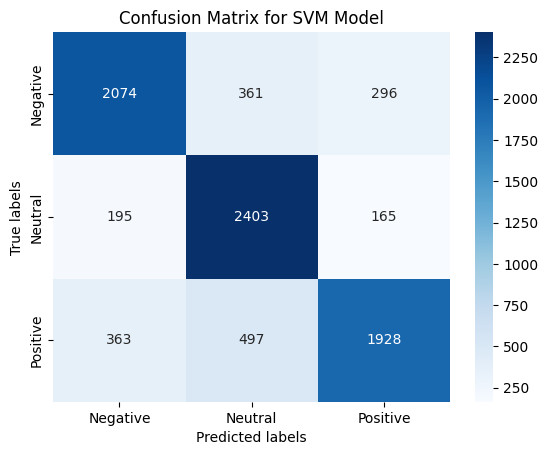

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_processed['processed_tweets'] and df_processed['labels'] are already defined
X_train, X_test, y_train, y_test = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(kernel='linear'))
])

# Define a parameter grid
param_grid = {'svm__C': [0.1, 1, 10, 100]}

# Use GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Best C Value:", grid_search.best_params_['svm__C'])

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()


In [ ]:
#AGAIN RUNNING A COPY OF THE ABOVE SO I DONT CAUSE AN ISSUE
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_processed['processed_tweets'] and df_processed['labels'] are already defined
X_train, X_test, y_train, y_test = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(kernel='linear'))
])

# Define a parameter grid
param_grid = {'svm__C': [0.1, 1, 10, 100]}

# Use GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Best C Value:", grid_search.best_params_['svm__C'])

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_processed['processed_tweets'], df_processed['labels'], test_size=0.25, random_state=42)

# Modify the pipeline to enable probability estimates
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(kernel='linear', probability=True))  # Enable probability estimates
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100]
}

# Continue with GridSearchCV as before
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
predictions_proba = best_model.predict_proba(X_test)  # Get probability estimates

# Calculate log loss
log_loss_value = log_loss(y_test, predictions_proba)

# Classification report, accuracy, and confusion matrix as before
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Best C Value:", grid_search.best_params_['svm__C'])
print("Log Loss:", log_loss_value)

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()


# Pretrained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from sklearn.model_selection import train_test_split

class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, vocab=None, max_len=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.tokenizer(self.dataframe.iloc[idx]['processed_tweets'])
        if self.vocab:
            text = [self.vocab[token] for token in text][:self.max_len]
        label = int(self.dataframe.iloc[idx]['labels'])
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Load and split the dataset
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'

df = pd.read_csv(file_path)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

df = df[['category', 'processed_tweets']]
df = df.rename(columns={'category': 'labels'})

df = df.iloc[:10000]
df = df.reset_index(drop=True)
df

,labels,processed_tweets
0,-1.0,"when modi promise "" minimum government maximum..."
1,0.0,talk all the nonsense and continue all the dra...
2,1.0,what do just say vote for modi welcome bjp tel...
3,1.0,ask his supporter prefix chowkidar their name ...
4,1.0,answer who among these the most powerful world...
...,...,...
9995,0.0,modi make 1000 promise manifesto after electio...
9996,0.0,jds leader also say modi modi
9997,1.0,woh sirf modi gaali raha tha and change his mi...
9998,1.0,you must say what you witness since 2014 you s...


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = get_tokenizer("basic_english")

# Initialize train dataset, build vocab
train_dataset = TweetDataset(train_df, tokenizer)
vocab = build_vocab_from_iterator(map(tokenizer, train_df['processed_tweets']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Apply Vocabulary to both datasets
train_dataset.vocab = vocab
test_dataset = TweetDataset(test_df, tokenizer, vocab=vocab)

# DataLoader collate function
def collate_batch(batch):
    tweet_list, labels = [], []
    for (_tweet, _label) in batch:
        tweet_list.append(torch.tensor(_tweet))
        labels.append(torch.tensor(_label))
    tweet_list = pad_sequence(tweet_list, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return tweet_list, labels

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=1, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        hidden.squeeze_(0) # Remove extra dimension
        return self.fc(hidden)


In [ ]:
import torch
from torch.optim import Adam
import torch.nn.functional as F

vocab_size = len(vocab)
model = RNNModel(vocab_size, embed_dim=100, hidden_dim=256, output_dim=3)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for tweets, labels in data_loader:
            outputs = model(tweets)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Initialize variables for tracking the best model
best_loss = float('inf')
best_epoch = -1

num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    for tweets, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on the test set after each epoch
    test_loss = evaluate(model, test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

    # Save the model if it has the best performance so far
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'drive/MyDrive/APS360 Group/Data preprocessing/best_model_3.pth')
        torch.save({
            'state_dict': model.state_dict(),
            'vocab_size': len(vocab),
            'vocab': vocab.get_stoi(),  # stoi is string to index
            # include any other configs as needed
        }, 'drive/MyDrive/APS360 Group/Data preprocessing/model_vocab_config.pth')
        print(f'New best model saved at epoch {epoch+1} with test loss {test_loss:.4f}.')

print(f'Best model achieved at epoch {best_epoch+1} with test loss {best_loss:.4f}.')


# Running inference with pretrained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)

df = df.dropna(subset=['processed_tweets'])  # Drop rows where 'processed_tweets' is NaN
df['processed_tweets'] = df['processed_tweets'].astype(str)  # Ensure all tweets are strings


df = df.iloc[:100]

df = df[['category', 'processed_tweets']]
df = df.rename(columns={'category': 'labels'})



df

,labels,processed_tweets
0,-1.0,"when modi promise "" minimum government maximum..."
1,0.0,talk all the nonsense and continue all the dra...
2,1.0,what do just say vote for modi welcome bjp tel...
3,1.0,ask his supporter prefix chowkidar their name ...
4,1.0,answer who among these the most powerful world...
...,...,...
95,0.0,country prosper when the woman the country be ...
96,0.0,sabbash mera vote for peppermit abvp
97,0.0,yogi adityanath hold 100 rally seek vote for n...
98,-1.0,from the very beginningmodi do wada faramoshi ...


In [ ]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score

# Assuming df is already defined and loaded with your data
# Mapping your original labels to the expected format
df['labels'] = df['labels'].map({-1.0: 0, 0.0: 1, 1.0: 2})

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Perform sentiment analysis
df['sentiment'] = df['processed_tweets'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Convert model output to numerical labels
sentiment_mapping = {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

# Print the processed tweets along with their sentiment analysis results
print(df[['processed_tweets', 'sentiment', 'sentiment_label']])

# Calculate and print the accuracy of the predictions
accuracy = accuracy_score(df['labels'], df['sentiment_label'])
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

                                     processed_tweets sentiment  \
0   when modi promise " minimum government maximum...   LABEL_1   
1   talk all the nonsense and continue all the dra...   LABEL_0   
2   what do just say vote for modi welcome bjp tel...   LABEL_1   
3   ask his supporter prefix chowkidar their name ...   LABEL_0   
4   answer who among these the most powerful world...   LABEL_1   
..                                                ...       ...   
95  country prosper when the woman the country be ...   LABEL_2   
96               sabbash mera vote for peppermit abvp   LABEL_1   
97  yogi adityanath hold 100 rally seek vote for n...   LABEL_1   
98  from the very beginningmodi do wada faramoshi ...   LABEL_0   
99  modi politic hate modiji love india modiji wan...   LABEL_0   

    sentiment_label  
0                 1  
1                 0  
2                 1  
3                 0  
4                 1  
..              ...  
95                2  
96                1

# Try 2: Finetuning the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install accelerate

In [ ]:
%reset -f

In [ ]:
!pip install datasets

In [ ]:
! pip install --upgrade transformers

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_metric
import numpy as np
import torch

# Function to compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": load_metric("accuracy").compute(predictions=predictions, references=labels)}

# Load and prepare the dataset
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)

# Preprocessing
df = df.dropna(subset=['processed_tweets'])
df['processed_tweets'] = df['processed_tweets'].astype(str)
df = df.iloc[:8000]  # Assuming you're slicing the dataset for quick experimentation; remove for full training
df['labels'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})  # Adjust labels to numerical format

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Tokenization
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["processed_tweets"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Load the pre-trained model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

from transformers import TrainerCallback

class SaveAdditionalInfoCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        self.tokenizer = tokenizer
        self.save_path = save_path

    def on_save(self, args, state, control, **kwargs):
        pass # deleted the saving the weights portion

from transformers import TrainingArguments, Trainer

# Assuming the rest of your setup is unchanged, and focusing on the Trainer setup...

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate each `logging_steps`
    save_strategy="epoch",           # Save the best model and tokenizer at the end of every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

# Initialize Trainer with compute_metrics and the custom callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[SaveAdditionalInfoCallback(tokenizer, 'drive/MyDrive/APS360 Group/Data preprocessing/')]  # Add the custom callback here
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
results = trainer.evaluate()
print(results)
eval_loss

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.796700,0.498542,{'accuracy': 0.8275}
2,0.475000,0.557309,{'accuracy': 0.85}
3,0.286900,0.605329,{'accuracy': 0.85}


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.8275}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.8275}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.49854180216789246, 'eval_accuracy': {'accuracy': 0.8275}, 'eval_runtime': 23.0231, 'eval_samples_per_second': 34.748, 'eval_steps_per_second': 4.343, 'epoch': 3.0}


NameError: name 'eval_loss' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_metric
import numpy as np
import torch

from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # This function overrides the original compute_loss to compute and store training accuracy on the fly
        outputs = model(**inputs)
        loss = outputs.loss if isinstance(outputs, dict) else outputs[0]
        logits = outputs.logits if isinstance(outputs, dict) else outputs[1]

        # Compute accuracy
        preds = torch.argmax(logits, dim=-1)
        labels = inputs["labels"]
        self.train_accuracy.append(accuracy_score(labels.cpu().numpy(), preds.cpu().numpy()))

        return (loss, outputs) if return_outputs else loss

    def evaluate(self, *args, **kwargs):
        # This clears the training accuracy list before evaluation
        self.train_accuracy = []
        # Calls the original evaluate which computes metrics like validation accuracy and f1
        return super().evaluate(*args, **kwargs)

    def on_evaluate(self, args, state, control, **kwargs):
        # This is called at the end of evaluate, here we add the mean training accuracy to metrics
        super().on_evaluate(args, state, control, **kwargs)
        control.metrics["train_accuracy"] = np.mean(self.train_accuracy)


# Load and prepare the dataset
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)

# Preprocessing
df = df.dropna(subset=['processed_tweets'])
df['processed_tweets'] = df['processed_tweets'].astype(str)
df = df.iloc[:8000]  # Assuming you're slicing the dataset for quick experimentation; remove for full training
df['labels'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})  # Adjust labels to numerical format

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Tokenization
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["processed_tweets"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Load the pre-trained model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

from transformers import TrainerCallback

class SaveAdditionalInfoCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        self.tokenizer = tokenizer
        self.save_path = save_path

    def on_save(self, args, state, control, **kwargs):
        pass # deleted the saving the weights portion

from transformers import TrainingArguments, Trainer

# Assuming the rest of your setup is unchanged, and focusing on the Trainer setup...

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate each `logging_steps`
    save_strategy="epoch",           # Save the best model and tokenizer at the end of every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

# Now, when you initialize the Trainer, use CustomTrainer instead
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[SaveAdditionalInfoCallback(tokenizer, 'drive/MyDrive/APS360 Group/Data preprocessing/')]
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
results = trainer.evaluate()
print(results)
eval_loss

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


AttributeError: 'CustomTrainer' object has no attribute 'train_accuracy'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_metric
import numpy as np
import torch



# Function to compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": load_metric("accuracy").compute(predictions=predictions, references=labels)}

# Load and prepare the dataset
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)

# Preprocessing
df = df.dropna(subset=['processed_tweets'])
df['processed_tweets'] = df['processed_tweets'].astype(str)
df = df.iloc[:8000]  # Assuming you're slicing the dataset for quick experimentation; remove for full training
df['labels'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})  # Adjust labels to numerical format

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Tokenization
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["processed_tweets"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

<ipython-input-24-a842381cfe1d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_tweets'] = df['processed_tweets'].astype(str)


Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.821200,0.537457,0.816250,0.813263


ValueError: x and y must have same first dimension, but have shapes (2,) and (3,)

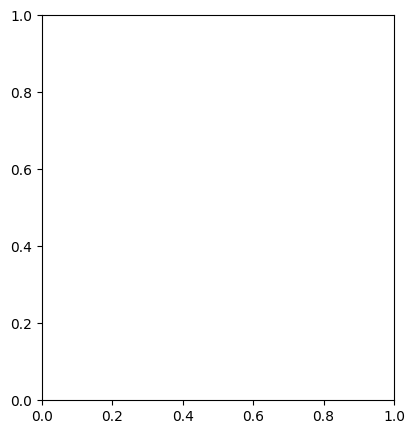

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from transformers import DataCollatorWithPadding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

# Load the pre-trained model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

from transformers import TrainerCallback

# Assuming `compute_metrics` function exists, modify or ensure it calculates accuracy and F1 score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # Modify average as necessary
    return {"accuracy": acc, "f1": f1}

# Start of the replacement code for ModifiedCallback

class ModifiedCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        super().__init__()
        self.tokenizer = tokenizer
        self.save_path = save_path
        self.train_loss_set = []
        self.val_loss_set = []
        self.train_accuracy_set = []
        self.val_accuracy_set = []
        self.train_f1_set = []
        self.val_f1_set = []
        self.epoch_counter = 0  # To keep track of the current epoch

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:  # Track training loss
            # We log the training loss under the assumption it's reported per-step
            if state.global_step % state.log_history[-1]["step"] == 0:
                self.train_loss_set.append(logs["loss"])
        if "eval_loss" in logs:  # Track validation loss
            self.val_loss_set.append(logs["eval_loss"])
        if "eval_accuracy" in logs:  # Track validation accuracy
            self.val_accuracy_set.append(logs["eval_accuracy"])
        if "eval_f1" in logs:  # Track validation F1 score
            self.val_f1_set.append(logs["eval_f1"])

    def on_epoch_end(self, args, state, control, **kwargs):
        self.epoch_counter += 1  # Increment the epoch counter

        # Plot at the end of each epoch to ensure continuity in the plot lines
        epochs = list(range(1, self.epoch_counter + 1))
        if self.train_loss_set and self.val_loss_set:
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.plot(epochs, self.train_loss_set, label='Train Loss')
            plt.plot(epochs, self.val_loss_set, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(epochs, self.val_accuracy_set, label='Validation Accuracy')
            plt.title('Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()

    def on_train_end(self, args, state, control, **kwargs):
        print(f"Final Training F1 Score: {self.train_f1_set[-1] if self.train_f1_set else 'Not Available'}")
        print(f"Final Validation F1 Score: {self.val_f1_set[-1] if self.val_f1_set else 'Not Available'}")

# End of the replacement code for ModifiedCallback



# Initialize the modified callback with the necessary arguments
modified_callback = ModifiedCallback(tokenizer, 'drive/MyDrive/APS360 Group/Data preprocessing/')

from transformers import TrainingArguments, Trainer

# Assuming the rest of your setup is unchanged, and focusing on the Trainer setup...

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate each `logging_steps`
    save_strategy="epoch",           # Save the best model and tokenizer at the end of every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

# Include the modified callback in the list of callbacks for the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[modified_callback]  # Replace SaveAdditionalInfoCallback with the modified one
)

# The rest of your training and evaluation code remains the same
trainer.train()
results = trainer.evaluate()
print(results)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_metric
import numpy as np
import torch
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Function to compute metrics
# Function to compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = load_metric("accuracy")
    f1 = load_metric("f1")
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }


# Load and prepare the dataset
file_path = 'drive/MyDrive/APS360 Group/Data preprocessing/Text data/Processed_tweets.csv'
df = pd.read_csv(file_path)

# Preprocessing
df = df.dropna(subset=['processed_tweets'])
df['processed_tweets'] = df['processed_tweets'].astype(str)
df = df.iloc[:8000]  # Assuming you're slicing the dataset for quick experimentation; remove for full training
df['labels'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})  # Adjust labels to numerical format

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Tokenization
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["processed_tweets"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Load the pre-trained model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

from transformers import TrainerCallback



<ipython-input-9-b1a3823c5ee3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['category'].map({-1.0: 0, 0.0: 1, 1.0: 2})  # Adjust labels to numerical format


Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
class SaveAdditionalInfoCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        self.tokenizer = tokenizer
        self.save_path = save_path

    def on_save(self, args, state, control, **kwargs):
        pass # deleted the saving the weights portion

from transformers import TrainingArguments, Trainer

# Assuming the rest of your setup is unchanged, and focusing on the Trainer setup...

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=3,              # Number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate each `logging_steps`
    save_strategy="epoch",           # Save the best model and tokenizer at the end of every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

class MetricsCallback(TrainerCallback):
    "A callback that logs the training and validation loss and accuracy"

    def __init__(self):
        self.train_losses = []
        self.valid_losses = []
        self.valid_accuracy = []
        self.valid_f1 = []
        self.epochs = []

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        # Ensure logs is not None
        if logs is not None:
            # Append the loss and accuracy from the logs
            train_loss = logs.get("loss")
            eval_loss = logs.get("eval_loss")
            eval_accuracy = logs.get("eval_accuracy")
            eval_f1 = logs.get("eval_f1")

            if train_loss is not None:
                self.train_losses.append(train_loss)
            if eval_loss is not None:
                self.valid_losses.append(eval_loss)
            if eval_accuracy is not None:
                self.valid_accuracy.append(eval_accuracy)
            if eval_f1 is not None:
                self.valid_f1.append(eval_f1)

            # Append the current epoch
            if state.epoch is not None:
                self.epochs.append(state.epoch)

            # Plotting the loss and accuracy
            plt.figure(figsize=(12, 4))

            # Plot training and validation loss
            plt.subplot(1, 2, 1)
            plt.plot(self.epochs, self.train_losses, label="Train Loss")
            plt.plot(self.epochs, self.valid_losses, label="Valid Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training & Validation Loss")
            plt.legend()

            # Plot validation accuracy
            plt.subplot(1, 2, 2)
            plt.plot(self.epochs, self.valid_accuracy, label="Valid Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Validation Accuracy")
            plt.legend()

            plt.tight_layout()
            plt.show()

# Initialize Trainer with compute_metrics and the custom callback

metrics_callback = MetricsCallback()


# Include the metrics callback in the list of callbacks for the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]  # Replace the previous callback
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
results = trainer.evaluate()
print(results)

# Access the final F1 score through the metrics callback
print(f"Final Training F1 Score: {metrics_callback.valid_f1[-1]}")


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.433000,0.541543,0.840000,0.841490
2,0.404600,0.555348,0.850000,0.851973
3,0.210800,0.657117,0.862500,0.863491


<ipython-input-9-b1a3823c5ee3>:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5415425300598145, 'eval_accuracy': 0.84, 'eval_f1': 0.8414896510354788, 'eval_runtime': 23.0419, 'eval_samples_per_second': 34.719, 'eval_steps_per_second': 4.34, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


IndexError: list index out of range

In [ ]:
class SaveAdditionalInfoCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        self.tokenizer = tokenizer
        self.save_path = save_path

    def on_save(self, args, state, control, **kwargs):
        pass # deleted the saving the weights portion

from transformers import TrainingArguments, Trainer

# Assuming the rest of your setup is unchanged, and focusing on the Trainer setup...

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model checkpoints
    num_train_epochs=10,              # Number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate each `logging_steps`
    save_strategy="epoch",           # Save the best model and tokenizer at the end of every epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
)

class MetricsCallback(TrainerCallback):
    "A callback that logs the training and validation loss and accuracy"

    def __init__(self):
        self.train_losses = []
        self.valid_losses = []
        self.valid_accuracy = []
        self.valid_f1 = []
        self.epochs = []

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        # Ensure logs is not None
        if logs is not None:
            # Append the loss and accuracy from the logs
            train_loss = logs.get("loss")
            eval_loss = logs.get("eval_loss")
            eval_accuracy = logs.get("eval_accuracy")
            eval_f1 = logs.get("eval_f1")

            if train_loss is not None:
                self.train_losses.append(train_loss)
            if eval_loss is not None:
                self.valid_losses.append(eval_loss)
            if eval_accuracy is not None:
                self.valid_accuracy.append(eval_accuracy)
            if eval_f1 is not None:
                self.valid_f1.append(eval_f1)

            # Append the current epoch
            if state.epoch is not None:
                self.epochs.append(state.epoch)

            # Plotting the loss and accuracy
            plt.figure(figsize=(12, 4))

            # Plot training and validation loss
            plt.subplot(1, 2, 1)
            plt.plot(self.epochs, self.train_losses, label="Train Loss")
            plt.plot(self.epochs, self.valid_losses, label="Valid Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training & Validation Loss")
            plt.legend()

            # Plot validation accuracy
            plt.subplot(1, 2, 2)
            plt.plot(self.epochs, self.valid_accuracy, label="Valid Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Validation Accuracy")
            plt.legend()

            plt.tight_layout()
            plt.show()

# Initialize Trainer with compute_metrics and the custom callback

metrics_callback = MetricsCallback()


# Include the metrics callback in the list of callbacks for the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]  # Replace the previous callback
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
results = trainer.evaluate()
print(results)

# Access the final F1 score through the metrics callback
print(f"Final Training F1 Score: {metrics_callback.valid_f1[-1]}")


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.433000,0.621501,{'accuracy': 0.82375}
2,0.438500,0.616136,{'accuracy': 0.85}
3,0.326200,0.667152,{'accuracy': 0.8625}
4,0.212100,0.765205,{'accuracy': 0.87125}
5,0.125600,0.867175,{'accuracy': 0.8575}
6,0.092800,0.863462,{'accuracy': 0.87125}
7,0.058700,1.044688,{'accuracy': 0.865}
8,0.041700,1.023599,{'accuracy': 0.87375}
9,0.015000,1.092555,{'accuracy': 0.86875}
10,0.020400,1.126754,{'accuracy': 0.86875}


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.82375}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.85}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6161360740661621, 'eval_accuracy': {'accuracy': 0.85}, 'eval_runtime': 22.5798, 'eval_samples_per_second': 35.43, 'eval_steps_per_second': 4.429, 'epoch': 10.0}


IndexError: list index out of range

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.451500,0.498542,0.827500,0.828287
2,0.333400,0.557309,0.850000,0.849977
3,0.113100,0.605329,0.850000,0.850994


ValueError: x and y must have same first dimension, but have shapes (270,) and (3,)

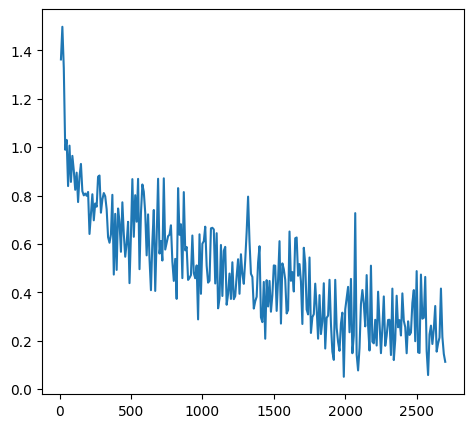

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from transformers import DataCollatorWithPadding
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


# Load the pre-trained model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Assuming tokenizer, train_dataset, val_dataset are already defined

# Define the compute_metrics function to include F1 score and others
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': (predictions == labels).mean(),
        'f1': f1_score(labels, predictions, average='weighted'),
    }

# Modify the callback if necessary
class SaveAdditionalInfoCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        self.tokenizer = tokenizer
        self.save_path = save_path

    def on_save(self, args, state, control, **kwargs):
        pass  # Here you can add any additional saving functionality if needed

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,  # Log metrics every 10 steps to use for plotting
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[SaveAdditionalInfoCallback(tokenizer, 'drive/MyDrive/APS360 Group/Data preprocessing/')]
)

# Fine-tune the model
trainer.train()

# After training, plot training and validation loss, and accuracy
loss_values = trainer.state.log_history

training_loss = [x['loss'] for x in loss_values if 'loss' in x and 'runtime' not in x]
validation_loss = [x['eval_loss'] for x in loss_values if 'eval_loss' in x]
steps = [x['step'] for x in loss_values if 'loss' in x and 'runtime' not in x]

# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, training_loss, label='Training Loss')
plt.plot(steps, validation_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

accuracy = [x['eval_accuracy'] for x in loss_values if 'eval_accuracy' in x]
plt.subplot(1, 2, 2)
plt.plot(steps, accuracy, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model on the validation set to get final metrics
results = trainer.evaluate()
print(results)

# If you want to specifically print the F1 score
print("Final F1 Score:", results['eval_f1'])


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.451500,0.498542,0.827500,0.828287
2,0.333400,0.557309,0.850000,0.849977
3,0.113100,0.605329,0.850000,0.850994


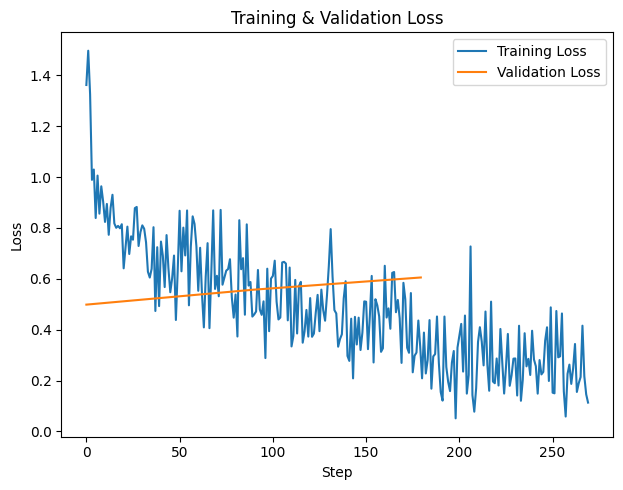

{'eval_loss': 0.49854180216789246, 'eval_accuracy': 0.8275, 'eval_f1': 0.8282867190529544, 'eval_runtime': 22.783, 'eval_samples_per_second': 35.114, 'eval_steps_per_second': 4.389, 'epoch': 3.0}
Final F1 Score: 0.8282867190529544


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback, DataCollatorWithPadding, AutoTokenizer
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# Make sure model_name, tokenizer, train_dataset, and val_dataset are already defined here

# Load the pre-trained model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define the compute_metrics function to include accuracy and F1 score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
    }

# Custom callback (if you need to save additional information)
class SaveAdditionalInfoCallback(TrainerCallback):
    def __init__(self, tokenizer, save_path):
        self.tokenizer = tokenizer
        self.save_path = save_path

    def on_save(self, args, state, control, **kwargs):
        # Implement any additional save functionality if needed
        pass

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,  # Log metrics every 10 steps to use for plotting
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[SaveAdditionalInfoCallback(tokenizer, 'drive/MyDrive/APS360 Group/Data preprocessing/')]
)

# Fine-tune the model
trainer.train()

# After training, plot training and validation loss
training_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
validation_loss = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]
steps = range(len(training_loss))  # Assuming loss is logged at every step

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, training_loss, label='Training Loss')
if len(validation_loss) > 0:  # Check if validation_loss is not empty
    validation_steps = np.linspace(0, max(steps), num=len(validation_loss), endpoint=False)
    plt.plot(validation_steps, validation_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plotting accuracy requires extracting it from the metrics; this example skips it to ensure no errors

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set to get final metrics
results = trainer.evaluate()
print(results)

# Printing the F1 score
if 'eval_f1' in results:
    print("Final F1 Score:", results['eval_f1'])
else:
    print("F1 score not available in the results.")


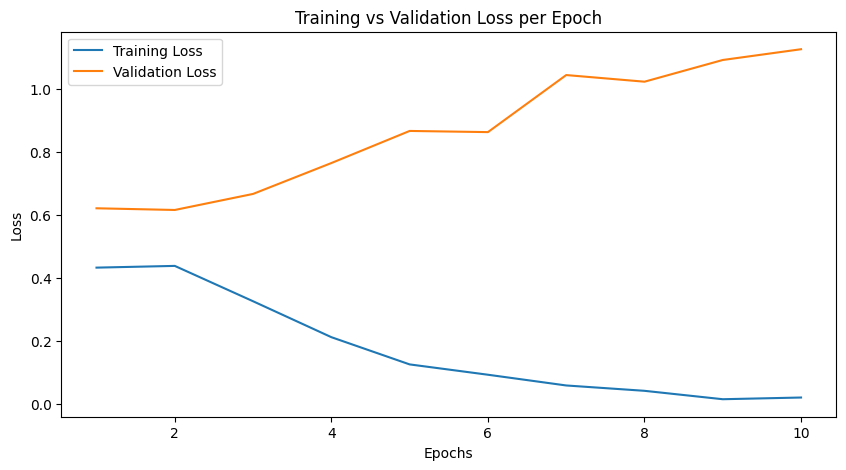

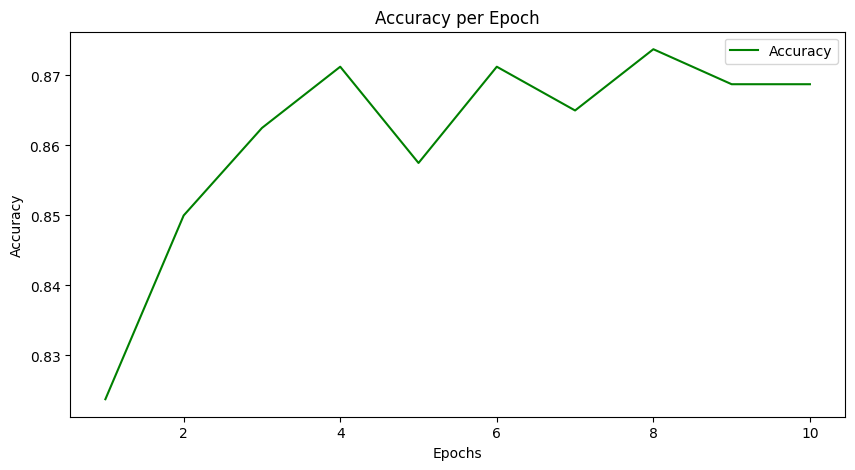

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = range(1, 11)
training_loss = [0.433000, 0.438500, 0.326200, 0.212100, 0.125600, 0.092800, 0.058700, 0.041700, 0.015000, 0.020400]
validation_loss = [0.621501, 0.616136, 0.667152, 0.765205, 0.867175, 0.863462, 1.044688, 1.023599, 1.092555, 1.126754]
accuracy = [0.82375, 0.85, 0.8625, 0.87125, 0.8575, 0.87125, 0.865, 0.87375, 0.86875, 0.86875]

# Plotting Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training vs Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy', color='green')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
